In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
from sklearn.cross_validation import cross_val_predict

from sklearn.pipeline import Pipeline

# used for train/test splits and cross validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
#import xgboost as xgb

# default colours for prettier plots

col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

from __future__ import print_function

In [3]:
df = pd.read_csv('got_data.csv', sep=',', index_col=0)
# who do we not have data for?
idxNoData = (df['Season(s)'].isnull())
df[idxNoData]

,Killing,SexNudity,Insult,Drinking,Injury,Total,Age,Allegiance,Also known as,Appeared in,...,Religion,Season(s),Status,Titles,Background,Season 1,Season 2,Season 3,Season 4,Season 5
Name,,,,,,,,,,,,,,,,,,,,,
Arianne_Martel,0,0,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ben_Plumm,0,0,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gerold_Dayne_The_Darkstar,0,0,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Griff,0,0,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lady_Stoneheart,0,0,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reznak_mo_Reznak,0,0,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ser_Arys_Oakheart,0,0,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Young_Griff,0,0,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# delete people with no data - they have no scores and never appeared in season 5
df = df.loc[~idxNoData]

In [12]:
plt.hist?

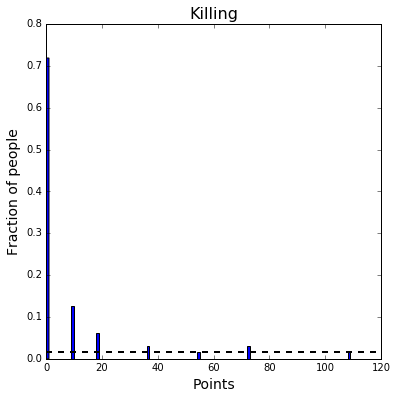

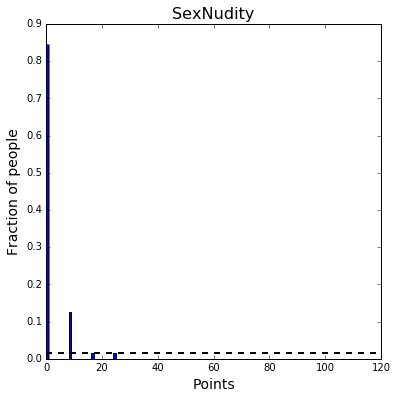

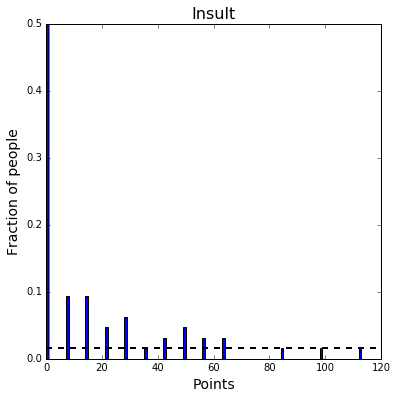

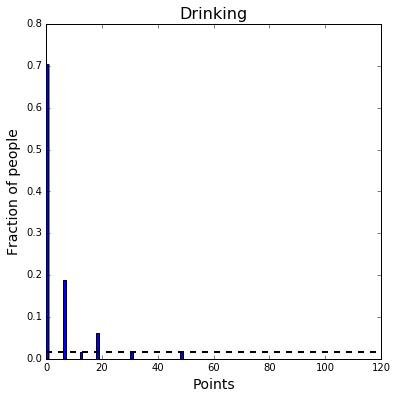

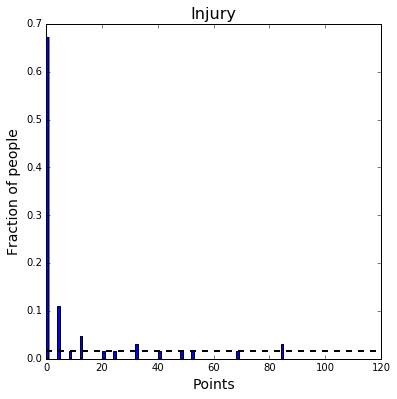

In [15]:
# visualize the data a bit
txt_outcome = ['Killing','SexNudity','Insult','Drinking','Injury']
for txt in txt_outcome:
    plt.figure(figsize=[6,6])
    plt.hist(df[txt],bins=range(120),normed=True)
    plt.plot([0,120], 1.0/df.shape[0]*np.ones(2), 'k--',lw=2 )
    plt.title(txt,fontsize=16)
    plt.xlabel('Points',fontsize=14)
    plt.ylabel('Fraction of people',fontsize=14)
    plt.show()

In [17]:
# calculate the number of words
txt_col = ['Background','Season 1','Season 2', 'Season 3', 'Season 4']
def count_words(s, phrase):
    if s is np.nan:
        return 0
    else:
        return len(re.findall(phrase,s, re.IGNORECASE))

def add_data(df_data, column_name, phrase):
    txt_col = ['Background','Season 1','Season 2', 'Season 3', 'Season 4']
    df_new = df[txt_col].applymap(lambda x: count_words(x,phrase))
    df_data[column_name] = df_new[txt_col].sum(axis=1)
    return df_data
    
# make a regression on scores using number of words in each season
idxData = np.ones(df.shape[0], dtype=bool)
df_data = df.loc[idxData, ['Killing']]

df_data = add_data (df_data, 'violent_words','(knight|warrior|sword|axe|spear|kill|murder|fight|assassinate)')
df_data = add_data (df_data, 'number_of_words','\w+')

df_data.head()

,Killing,violent_words,number_of_words
Name,,,
Aeron_Greyjoy,0,0,46
Areo_Hotah,0,2,56
Arya_Stark,18,57,4730
Balon_Greyjoy,0,6,1505
Barristan_Selmy,72,28,1895


In [55]:
X = df_data[idxData].values
target = X[:,0]
X = X[:,1:X.shape[1]]
X[0:5,:]

array([[   0,   46],
       [   2,   56],
       [  57, 4730],
       [   6, 1505],
       [  28, 1895]], dtype=int64)

lr         0.799259 [0.666667, 0.962963]


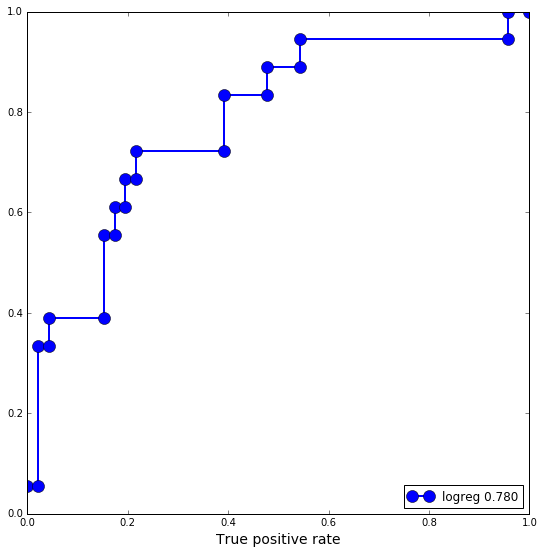

In [56]:
# logistic regression
y = target > 0


# workaround cross_val_predict returning 0s/1s
class proba_logreg(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)
    
mdl = "logreg"
model = LogisticRegression(fit_intercept=True)
estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ("lr", model)])

scores = cross_val_score(estimator, X, y, scoring='roc_auc',cv=5)
print('{:10s} {:5g} [{:5g}, {:5g}]'.format("lr", np.mean(scores), np.min(scores), np.max(scores) ))

# plot a roc curve
predicted = cross_val_predict(proba_logreg(), X, y, cv=10)
predicted = predicted[:,1]

plt.figure(figsize=[9,9])
ax = plt.gca()
fpr, tpr, thresholds = metrics.roc_curve(y, predicted, pos_label=1)
plt.plot(fpr, tpr, 'bo-',lw=2,markersize=12,
        label=mdl + ' ' + '%0.3f' % metrics.auc(fpr, tpr))
plt.xlabel('False positive rate',fontsize=14)
plt.xlabel('True positive rate',fontsize=14)
plt.legend(loc='lower right')
plt.show()

In [47]:
print(mdl + ' ' + '%0.3f' % metrics.auc(fpr, tpr))

logreg 0.780


lr         6.07683 [8.38205, 4.84113]


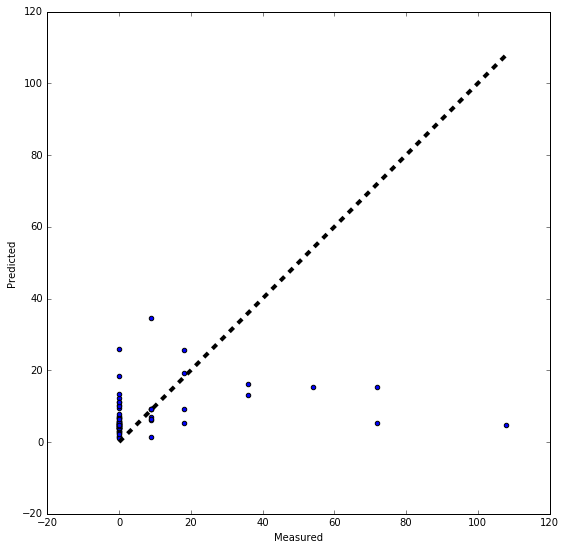

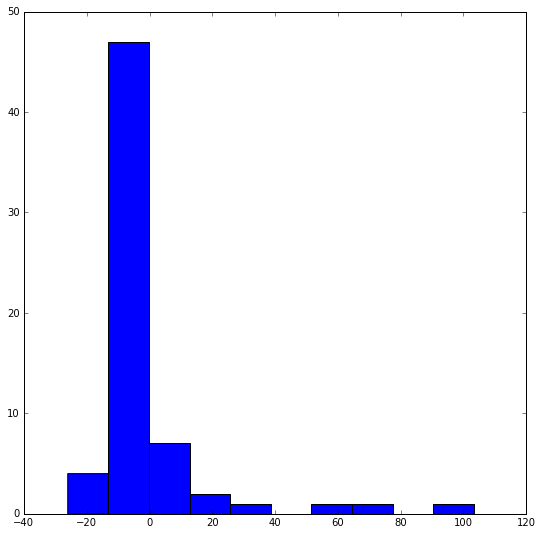

In [35]:
# linear regression
y = target

mdl = "lr"
model = LinearRegression(fit_intercept=True)
estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ("lr", model)])

scores = cross_val_score(estimator, X, y, scoring='median_absolute_error',cv=5)
# note that some error metrics are negated in cross_val_score so that all metrics can be maximized for optimization
print('{:10s} {:5g} [{:5g}, {:5g}]'.format("lr", -np.mean(scores), -np.min(scores), -np.max(scores) ))

predicted = cross_val_predict(model, X, y, cv=10)

plt.figure(figsize=[9,9])
ax = plt.gca()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=[9,9])
plt.hist(y - predicted)
plt.show()

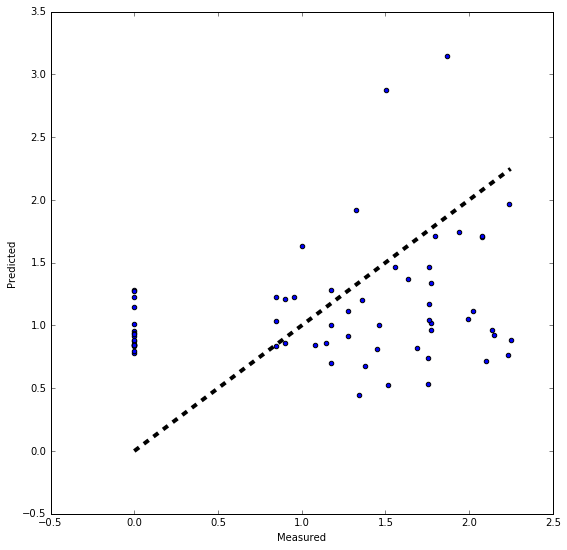

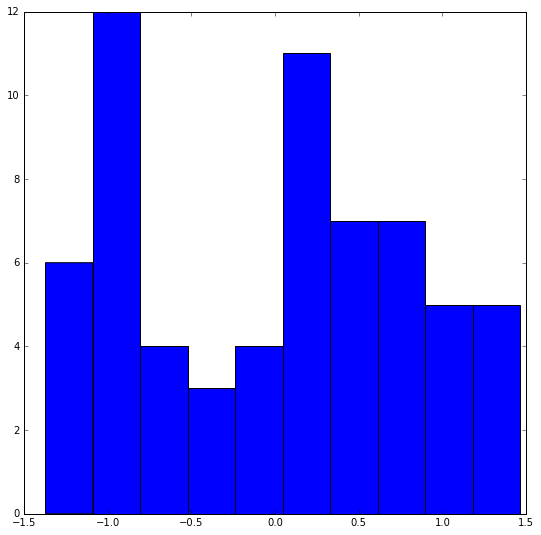

In [44]:
y = np.log10(target+1)
estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])])

predicted = cross_val_predict(LinearRegression(fit_intercept=True), X, y, cv=10)

plt.figure(figsize=[9,9])
ax = plt.gca()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=[9,9])
plt.hist(y - predicted)
plt.show()